In [ ]:
!pip install setuptools==64.0.2
!apt-get install swig
!pip install wrds
!pip install git+https://github.com/AI4Finance-LLC/FinRL-Library.git
!pip install git+https://github.com/AI4Finance-Foundation/FinRL.git



In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl.config_tickers import DOW_30_TICKER
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent,DRLEnsembleAgent
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline
from stable_baselines3.common.logger import configure
from finrl.meta.data_processor import DataProcessor
from pprint import pprint

import sys
sys.path.append("../FinRL")

import itertools

from finrl import config
from finrl import config_tickers
import os
from finrl.main import check_and_make_directories
from finrl.config import (
  DATA_SAVE_DIR,
  TRAINED_MODEL_DIR,
  TENSORBOARD_LOG_DIR,
  RESULTS_DIR,
  INDICATORS,
  TRAIN_START_DATE,
  TRAIN_END_DATE,
  TEST_START_DATE,
  TEST_END_DATE,
  TRADE_START_DATE,
  TRADE_END_DATE,
)



In [4]:

check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])



In [5]:
def load_data(ticker,START_DATE,END_DATE):
  df = YahooDownloader(start_date=START_DATE,
                      end_date=END_DATE,
                      ticker_list=ticker).fetch_data()

                      
  return df


In [6]:
def prepare_it(df): 
  df.sort_values(['date', 'tic'], ignore_index=True).head()
  list_ticker = df["tic"].unique().tolist()
  fe = FeatureEngineer(
      use_technical_indicator=True,
      tech_indicator_list=INDICATORS,
      use_vix=True,
      use_turbulence=True,
      user_defined_feature=False)

  processed = fe.preprocess_data(df)
  
  list_date = list(pd.date_range(processed['date'].min(), processed['date'].max()).astype(str))
  
  combination = list(itertools.product(list_date, list_ticker))

  processed_full = pd.DataFrame(combination, columns=["date", "tic"]).merge(processed, on=["date", "tic"], how="left")
  processed_full = processed_full[processed_full['date'].isin(processed['date'])]
  processed_full = processed_full.sort_values(['date', 'tic'])

  processed_full = processed_full.fillna(0)

  processed_full.sort_values(['date', 'tic'], ignore_index=True).head(10)
  mvo_df = processed_full.sort_values(['date', 'tic'], ignore_index=True)[['date', 'tic', 'close']]

  return processed_full



In [7]:
def get_train_test_data(processed_df,TRAIN_START_DATE,TRAIN_END_DATE,TEST_START_DATE,TEST_END_DATE):
    train = data_split(processed_df, TRAIN_START_DATE, TRAIN_END_DATE)
    test = data_split(processed_df, TEST_START_DATE, TEST_END_DATE)
    print(len(train))
    print(len(test))
    return train,test



In [8]:
def get_env_args(df):
    stock_dimension = len(df.tic.unique())
    state_space = 1 + 2 * stock_dimension + len(INDICATORS) * stock_dimension
    print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

    buy_cost_list = sell_cost_list = [0.001] * stock_dimension
    num_stock_shares = [0] * stock_dimension

    env_kwargs = {
          "hmax": 100,
          "initial_amount": 1000000,
          "num_stock_shares": num_stock_shares,
          "buy_cost_pct": buy_cost_list,
          "sell_cost_pct": sell_cost_list,
          "state_space": state_space,
          "stock_dim": stock_dimension,
          "tech_indicator_list": INDICATORS,
          "action_space": stock_dimension,
          "reward_scaling": 1e-4
      }

    return env_kwargs



In [9]:
def train_model(model_name,df):
  ppo_model_path = '/content/trained_models/ppo.zip'
  if os.path.isfile(ppo_model_path)   :
    print("model is already trained..")
    return 
  env_kwargs = get_env_args(df)
  e_train_gym = StockTradingEnv(df=train, **env_kwargs)
  env_train, _ = e_train_gym.get_sb_env()
  agent = DRLAgent(env=env_train)

  if model_name == 'ppo':
      PPO_PARAMS = {
            "n_steps": 1024,
            "ent_coef": 0.01,
            "learning_rate": 0.00025,
            "batch_size": 128,
        }
      model_ppo = agent.get_model("ppo", model_kwargs=PPO_PARAMS)

      # set up logger
      tmp_path = RESULTS_DIR + '/ppo'
      new_logger_ppo = configure(tmp_path, ["stdout", "csv", "tensorboard"])
      # Set new logger
      model_ppo.set_logger(new_logger_ppo)

      trained_ppo = agent.train_model(model=model_ppo,
                                      tb_log_name='ppo',
                                      total_timesteps=5024) 
      trained_ppo.save(ppo_model_path) 

In [10]:
def getTradingEnv(df):
  env_kwargs = get_env_args(df)
  e_trade_gym = StockTradingEnv(df=df, turbulence_threshold=70, risk_indicator_col='vix', **env_kwargs,make_plots=True) 
 
  return e_trade_gym

In [11]:
def get_model():
  model_path = "/content/trained_models/ppo.zip"
  model = PPO.load(model_path) 
  return model

In [12]:
def test_model(model_name,df):
  model_path = "/content/trained_models/ppo.zip"
  model = PPO.load(model_path)  

  env_kwargs = get_env_args(df)
  e_trade_gym = StockTradingEnv(df=df, turbulence_threshold=70, risk_indicator_col='vix', **env_kwargs) 
  df_account_value, df_actions_ppo = DRLAgent.DRL_prediction(
                                                      model=model,
                                                      environment=e_trade_gym)
  sharpe=(252**0.5)*df_account_value.account_value.pct_change(1).mean()/df_account_value.account_value.pct_change(1).std()
  print('Sharpe Ratio: ',sharpe)
  print("==============Get Backtest Results===========")
  now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

  perf_stats_all = backtest_stats(account_value=df_account_value)
  perf_stats_all = pd.DataFrame(perf_stats_all)
  #baseline stats
  print("==============Get Baseline Stats===========")
  baseline_df = get_baseline(
          ticker="^DJI", 
          start = df_account_value.loc[0,'date'],
          end = df_account_value.loc[len(df_account_value)-1,'date'])

  stats = backtest_stats(baseline_df, value_col_name = 'close')
  print("==============Compare to DJIA===========")
  %matplotlib inline
  # S&P 500: ^GSPC
  # Dow Jones Index: ^DJI
  # NASDAQ 100: ^NDX
  backtest_plot(df_account_value, 
              baseline_ticker = '^DJI', 
              baseline_start = df_account_value.loc[0,'date'],
              baseline_end = df_account_value.loc[len(df_account_value)-1,'date'])


In [13]:
from stable_baselines3 import PPO
def init_and_process(ticker):
  TRAIN_START_DATE = '2010-01-01'
  TRAIN_END_DATE = '2022-10-01'
  TEST_START_DATE = '2022-04-01'
  TEST_END_DATE = '2023-04-20'

  df = load_data(ticker,TRAIN_START_DATE,TEST_END_DATE)
  df.head()
  processed = prepare_it(df)
  train,test = get_train_test_data(processed,TRAIN_START_DATE,TRAIN_END_DATE,TEST_START_DATE,TEST_END_DATE)
  
  return train,test
  



In [14]:
train,test = init_and_process(['IBM'])

[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (3346, 8)
Successfully added technical indicators
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (3345, 8)
Successfully added vix
Successfully added turbulence index
3209
262


In [ ]:
train_model('ppo',train)

In [ ]:
test_model('ppo',test)

In [18]:
#!cp -r "/content/trained_models"  "/content/drive/MyDrive"

In [23]:
env = getTradingEnv(test)

Stock Dimension: 1, State Space: 11


In [36]:
import matplotlib.pyplot as plt
def plt_graph(graph,df):
  x = df['date']
  y1 = graph["pf"]
  y2 = graph["pos"]
  y3 = graph["price"]

  # Create the subplots
  fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))

  # Plot the data in each subplot
  ax1.plot(x, y1)
  ax1.set_title('Portfolio value')
  ax2.plot(x, y2)
  ax2.set_title('Stock Holding')
  ax3.plot(x, y3)
  ax3.set_title('stock price')

  # Add a common x-label and y-label
  fig.text(0.5, 0.04, 'X-axis', ha='center')
  fig.text(0.04, 0.5, 'Y-axis', va='center', rotation='vertical')

  # Show the plot
  plt.show()

In [19]:
def map_action(action):
    if action > 0.5:
        return "buy"
    elif action < -0.5:
        return "sell"
    else:
        return "hold"

In [33]:
import time
start_time = time.time()
TEST_START_DATE = '2023-04-01'
TEST_END_DATE = '2023-04-15'
trade_test = data_split(test, TEST_START_DATE, TEST_END_DATE)
env = getTradingEnv(trade_test)
obs = env.reset()
env.current_step=0
done = False
info= {}
graph = {"pf":[],"price": [] , "pos":[]}
trained_model = get_model()
while not done:
    action, _states = trained_model.predict(obs)
    #actions = action * 100  # actions initially is scaled between 0 to 1
    #actions = actions.astype(int) # convert into integer because we can't by fraction of shares
    rl_action = map_action(action)  
    #print(actions)
    # print("current action by RL :" + rl_action)
    # user_action = input ("want to override buy:1 sell: 2 :") 
    # if user_action == 1:
    #     action = 1
    # elif user_action == 2:
    #     action  = -1

    

      
    obs, rewards, done, info = env.step(action)
    x = env.render(mode='rgb_array')
    graph["pf"].append(x[0])
    graph["price"].append(x[1])
    graph["pos"].append(x[2])
    #print(x[0],x[1],x[2])
    
    
    if done :
      print(info)

print(f"--- running time: {(time.time() - start_time)}---")




Stock Dimension: 1, State Space: 11
{}
--- running time: 0.23775267601013184---


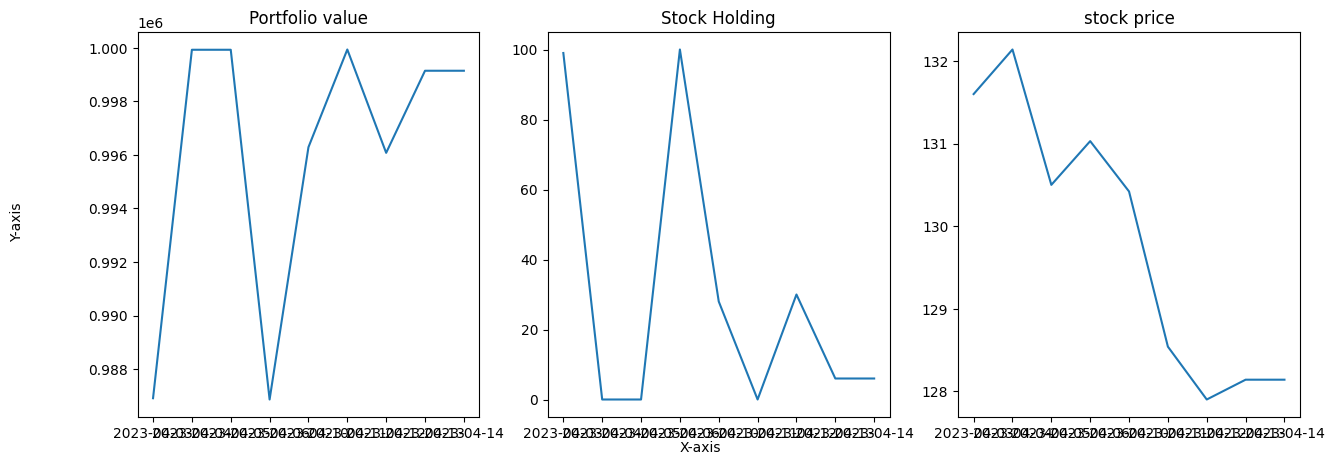

In [37]:
%matplotlib inline
plt_graph(graph,trade_test)

In [ ]:
import time
import alpaca_trade_api as tradeapi

# define Alpaca API credentials
api_key = 'XX'
api_secret = 'XX'
base_url = 'https://paper-api.alpaca.markets'

# instantiate Alpaca API object
api = tradeapi.REST(api_key, api_secret, base_url, api_version='v2')

# set up trading parameters
SYMBOL = 'IBM'  # example stock symbol
ORDER_QTY = 10  # example order quantity

start_time = time.time()
TEST_START_DATE = '2023-04-01'
TEST_END_DATE = '2023-04-15'

# split data for testing
trade_test = data_split(test, TEST_START_DATE, TEST_END_DATE)

# create trading environment
env = getTradingEnv(trade_test)
obs = env.reset()
env.current_step = 0
done = False
info = {}
graph = {"pf": [], "price": [], "pos": []}

# get trained PPO model
trained_model = get_model()

# start paper trading loop
while not done:
    # predict action using PPO model
    action, _states = trained_model.predict(obs)
    # map PPO action to buy/sell order
    rl_action = map_action(action)
    # get current stock price
    current_price = last_trade = api.get_latest_trade(symbol=SYMBOL).p

    # submit buy/sell order based on PPO action
    if rl_action == "buy":
        order = api.submit_order(
            symbol=SYMBOL,
            qty=ORDER_QTY,
            side='buy',
            type='limit',
            time_in_force='gtc',
            limit_price=current_price
        )
        print(f"BUY {ORDER_QTY} shares of {SYMBOL} at {current_price}")
    elif rl_action == "sell":
        order = api.submit_order(
            symbol=SYMBOL,
            qty=ORDER_QTY,
            side='sell',
            type='limit',
            time_in_force='gtc',
            limit_price=current_price
        )
        print(f"SELL {ORDER_QTY} shares of {SYMBOL} at {current_price}")
    else:
        print("HOLD position")

    # step the trading environment and get next observation
    obs, rewards, done, info = env.step(action)
    
    # add data for plotting to graph dictionary
    x = env.render(mode='rgb_array')
    graph["pf"].append(x[0])
    graph["price"].append(x[1])
    graph["pos"].append(x[2])
    
    # print current portfolio value and cash balance
    portfolio_value = api.get_account().portfolio_value
    cash_balance = api.get_account().cash
    print(f"Portfolio Value: ${portfolio_value}, Cash Balance: ${cash_balance}")

    # wait for a few seconds before next iteration
    time.sleep(5)

print(f"--- running time: {(time.time() - start_time)}---")
